In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
from numpy import random

from plotnine import *
%matplotlib inline

# Quasi-experimental techniques

We don't always have the luxury of being able to obtain experiment data. In general, we have to deal with the fact that our treatment is not assigned at random but determined by external factors that might select who gets the treatment ("selection bias") making the treated and untreated groups no longer comparable.

However, we could think of ways in which we can find sufficiently comparable groups under certain assumptions that would allow us to get away from selection bias. These techniques are highly sophisticated in terms of the logic, and can be quite difficult to apply, but they are mostly based on simple prediction models shaped to perform causal evaluation. 


## Regression Discontinuity Design (RDD)


You can read my blogpost on Medium about this [too](https://medium.com/@pabloalejandrocrespo/a-regression-discontinuity-love-story-quasi-experimental-tools-in-the-age-of-a-b-tests-8a8c172fb42c).

The image below is taken from Scott Cunningham's book "Causal Inference: The Mixtape":

![RDD popularity](https://mixtape.scunning.com/graphics/RDD_overtime.jpg)

As you can see, RDD is a technique that has gained incredible popularity over the last few years. But why? The reason is simple, RDD is capable of mostly eliminating selection bias. So, how do we actually identify an effect with this technique when we don't have experiment data?

RDD takes advantage of the fact that we might have some overlapping policy that creates natural thresholds in the data. For example:

* Border lines that separate Catholic and Protestant provinces in Austria
* A cut-off score for standardized tests for college admissions
* An age limit for consumption of specific substances
* Star ratings on Yelp!


In general we can find these exogenous thresholds as what we would consider a treatment and think of our data dispersed a certain distance away from the threshold.

This part is important! We can think for example that a treatment is providing people with a loan. Then the thresholds on credit scores a bank uses to provide the loan are an indication of treatment. And they have a very important property, they are continuous. So we know how far anybody is from being in the treated group if they are in the control. Continuous variables that can provide us with thresholds that will eventually give us the treatment assignment are called 'running variables.' 

The wonderful thing about this idea of distance is that it can find us find comparable individuals across the sides of the threshold. 

Think about it. If the credit score threshold for getting a loan might be 650. If you picture two people, one with score 649 and the other with score of 651 we will have that one is not treated while one is, but they are most definitively comparable in terms of all of their financial  behavior or most relevant characteristics. 

## Potential outcome notation review and looking at the mathematics of RDD

Recall the notation we learned last class, a certain outcome $Y$ can be notated differently if it happens to a member of the treated class or a member of the control class. 

We use $Y^0$ for units in the control class and $Y^1$ for members of the treated class.

We define $\delta$ as the treatment effect

In addition we had made generalizations that allowed us to express the outcomes in simple equations. First we define a treatment indicator $T$


$$T=\begin{cases}
        1, \mbox{if Treated}\\ 
        0, \mbox{Otherwise} \\
        \end{cases}$$
        
And also a general specification of outcomes:

$$Y=\begin{cases}
        Y^1, \mbox{if Treated}\\ 
        Y^0, \mbox{Otherwise} \\
        \end{cases}$$
        
Which can then be summarized by the switching equation:

$$Y=Y^0+(Y^1-Y^0)T$$


Let us now introduce the running variable $X$ and a value of it that will be the threshold. Let's name the threshold $c_0$, then we know that for any value of $X$ that is above the threshold we have that treatment has been assigned. Let's rewrite our $T$

$$T=\begin{cases}
        1, \mbox{if }X\geq c_0\\ 
        0, \mbox{if }X<c_0 \\
        \end{cases}$$

We could now redefine our equation for $Y^0$ as:

$$Y^0=\alpha+\beta X$$

And recall that:

$$Y^1=Y^0+\delta$$

Let us take the switching equation and use our recent definitions:

$$Y=Y^0+(Y^1-Y^0)T$$

$$Y=\alpha+\beta X+\delta T+\varepsilon$$

And recalling that $X$ now determines $T$, we can redifine the idea of $\delta$ as:

$$\delta=\underset{X\rightarrow c_0}{\mbox{lim}}\mbox{mean}(Y^1 \mbox{conditioned on}X=c_0)-\underset{c_0\leftarrow X}{\mbox{lim}}\mbox{mean}(Y^0 \mbox{conditioned on}X=c_0)$$

Meaning, that the treatment effect can be estimated by looking at the difference between the mean of the outcomes of the observations near the threshold.

This means we do need sufficient data near the threshold to make the comparison, but we still have a way to identify our treatment effect! This is of course only found around the threshold, so we call it the LATE or local average treatment effect.

Let's replicate the Carpenter and Dobkin (2009) study about the MLDA (minimum legal drinking age) and mortality rates.


In [2]:
#Reading the data

alc_df=pd.read_csv('Mortrate.csv')

In [3]:
#Let's look at this

alc_df.head()

,Unnamed: 0,agecell,all,allfitted,internal,internalfitted,external,externalfitted,alcohol,alcoholfitted,homicide,homicidefitted,suicide,suicidefitted,mva,mvafitted,drugs,drugsfitted,externalother,externalotherfitted
0,1,19.068493,92.825401,91.706146,16.617590,16.738131,76.207817,74.968010,0.639138,0.794344,16.316818,16.284573,11.203714,11.592100,35.829327,34.817780,3.872425,3.448835,8.534373,8.388236
1,2,19.150684,95.100739,91.883720,18.327684,16.920654,76.773056,74.963066,0.677409,0.837575,16.859964,16.270697,12.193368,11.593611,35.639256,34.633888,3.236511,3.470022,8.655786,8.530174
2,3,19.232876,92.144295,92.049065,18.911053,17.098843,73.233238,74.950226,0.866443,0.877835,15.219254,16.262882,11.715812,11.595129,34.205650,34.446735,3.202071,3.492069,8.513741,8.662681
3,4,19.315069,88.427757,92.202141,16.101770,17.272680,72.325981,74.929466,0.867308,0.915115,16.742825,16.261148,11.275010,11.596655,32.278957,34.256302,3.280689,3.514980,8.258285,8.785728
4,5,19.397261,88.704941,92.342918,17.363520,17.442156,71.341415,74.900757,1.019163,0.949407,14.947726,16.265511,10.984314,11.598189,32.650967,34.062588,3.548198,3.538755,8.417533,8.899288


Here we have that agecell represents the binned ages for people bucketed for people born in a specific month and all represents the number of those who have died. in that bucket per 100,000 people. Let's look at this data:

/Users/pablocrespo/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


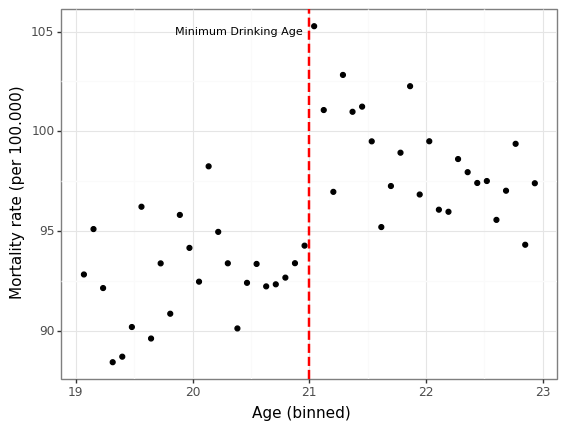

<ggplot: (8783686299272)>

In [4]:
(ggplot(data=alc_df, mapping=aes(x='agecell', y='all'))+
       geom_point()+
  geom_vline(xintercept = 21, color = "red", size = 1, linetype = "dashed")+
 annotate("text", x = 20.4, y = 105, label = "Minimum Drinking Age",
           size=8)+
 labs(y = "Mortality rate (per 100.000)",
       x = "Age (binned)")+
 theme_bw()
 
       )

We already see that there might be some reason for us to believe that there is a different between the sides of the threshold. Let's create a treatment indicator based on the threshold:

In [5]:
alc_df['threshold']=np.where(alc_df['agecell']>=21, 1, 0)

# For the sake of making things more readable we will also create a centered
#age variable, this transformation won't affect the results

alc_df['centered']=alc_df['agecell']-21



Let's just make an attempt at doing the regression without changing much:

In [6]:
reg1 = smf.ols('all ~ threshold+centered',alc_df).fit()

reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    all   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     32.99
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           1.51e-09
Time:                        15:54:58   Log-Likelihood:                -110.41
No. Observations:                  48   AIC:                             226.8
Df Residuals:                      45   BIC:                             232.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.8414      0.805    114.083      0.000      90.220      93.463
threshold      7.6627      1.440      5.320      0.000       4.762      10.564
centered      -0.9747      0.632     -1.541      0.130      -2.249       0.299
==============================================================================
Omnibus:                        0.189   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.910   Jarque-Bera (JB):                0.194
Skew:                           0.131   Prob(JB):                        0.907
Kurtosis:                       2.831   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
reg2 = smf.ols('all ~ threshold+agecell',alc_df).fit()

reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    all   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     32.99
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           1.51e-09
Time:                        15:56:41   Log-Likelihood:                -110.41
No. Observations:                  48   AIC:                             226.8
Df Residuals:                      45   BIC:                             232.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.3097     12.668      8.866      0.000      86.795     137.825
threshold      7.6627      1.440      5.320      0.000       4.762      10.564
agecell       -0.9747      0.632     -1.541      0.130      -2.249       0.299
==============================================================================
Omnibus:                        0.189   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.910   Jarque-Bera (JB):                0.194
Skew:                           0.131   Prob(JB):                        0.907
Kurtosis:                       2.831   Cond. No.                         746.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our local treatment effect estimate is the parameter for threshold. Here we have that the difference in mortality caused by the drinking age limit is 7.66 pero 100000 on average. Let's visualize this regression.

/Users/pablocrespo/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


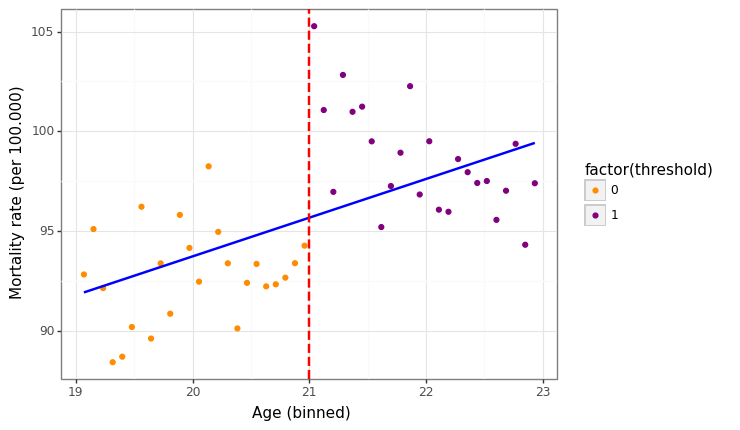

<ggplot: (8783686346611)>

In [7]:
(ggplot(data=alc_df, mapping=aes(x='agecell', y='all'))+
       geom_point(aes(color='factor(threshold)'))+
 scale_color_manual(values=['darkorange', 'purple'])+
 geom_smooth(method='lm', se=False, color='blue')+
 geom_vline(xintercept = 21, color = "red", size = 1, linetype = "dashed")+
 labs(y = "Mortality rate (per 100.000)",
       x = "Age (binned)")+
 theme_bw()
)

Well, I am stil not necessarily convinced this regression is great, and also the slope shows me nothing interesting. Let's create a regression that actually looks like this:

$$Y=\alpha+\beta X+\delta T+\gamma XT+\varepsilon$$

In which we make sure that we are interacting the running variable with the treatment assignment (although we probably did that already), and also plot the regression when we do not assume that both slopes should be the same on each side of the regression.

Let's create the cross


In [10]:
alc_df['cross']=alc_df['threshold']*alc_df['centered']

Let's do the regression:

In [11]:
reg2 = smf.ols('all ~ threshold+centered+cross',alc_df).fit()

reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    all   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     29.47
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           1.33e-10
Time:                        16:02:33   Log-Likelihood:                -105.64
No. Observations:                  48   AIC:                             219.3
Df Residuals:                      44   BIC:                             226.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.6184      0.932    100.399      0.000      91.739      95.498
threshold      7.6627      1.319      5.811      0.000       5.005      10.320
centered       0.8270      0.819      1.010      0.318      -0.823       2.477
cross         -3.6034      1.158     -3.111      0.003      -5.937      -1.269
==============================================================================
Omnibus:                        0.294   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.411
Skew:                           0.167   Prob(JB):                        0.814
Kurtosis:                       2.693   Cond. No.                         7.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that we have the same LATE and it is still significant! How about we plot it now without assuming each side has the same slope.

/Users/pablocrespo/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


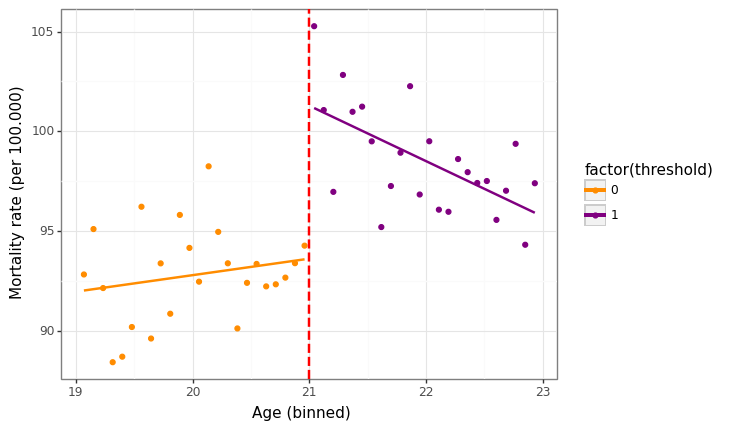

<ggplot: (8783686368199)>

In [9]:
(ggplot(data=alc_df, mapping=aes(x='agecell', y='all', 
                                 color='factor(threshold)'))+
       geom_point()+
 scale_color_manual(values=['darkorange', 'purple'])+
 geom_smooth(method='lm', se=False)+
 geom_vline(xintercept = 21, color = "red", size = 1, linetype = "dashed")+
 labs(y = "Mortality rate (per 100.000)",
       x = "Age (binned)")+
 theme_bw()
)

We can now CLEARLY see that 7.6 difference at the threshold line and we know that the slopes of the regressions on both sides. So what about if we had something that is not just linear? Like a polynomial, would we really see the break? Or be able to measure it? Let's try this equation: 

$$Y=\alpha+\beta_1 X+\beta_2 X^2 +\delta T+\gamma_1 XT+\gamma_2 X^2 T+\varepsilon$$

Let's make the adequate vars:


In [12]:
#Squared term
alc_df['csq']=alc_df['centered']**2
#Squared cross term
alc_df['crosssq']=alc_df['csq']*alc_df['threshold']

In [13]:
reg3 = smf.ols('all ~ threshold+centered+cross+csq+crosssq',alc_df).fit()

reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    all   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     18.02
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           1.62e-09
Time:                        16:04:42   Log-Likelihood:                -104.57
No. Observations:                  48   AIC:                             221.1
Df Residuals:                      42   BIC:                             232.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.0729      1.404     66.301      0.000      90.240      95.906
threshold      9.5478      1.985      4.809      0.000       5.541      13.554
centered      -0.8306      3.290     -0.252      0.802      -7.470       5.809
cross         -6.0170      4.653     -1.293      0.203     -15.407       3.373
csq           -0.8403      1.615     -0.520      0.606      -4.100       2.419
crosssq        2.9042      2.284      1.271      0.211      -1.706       7.514
==============================================================================
Omnibus:                        0.040   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.980   Jarque-Bera (JB):                0.203
Skew:                           0.049   Prob(JB):                        0.903
Kurtosis:                       2.697   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see it being significant still. And even a bit higher than before! 9.54

/Users/pablocrespo/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


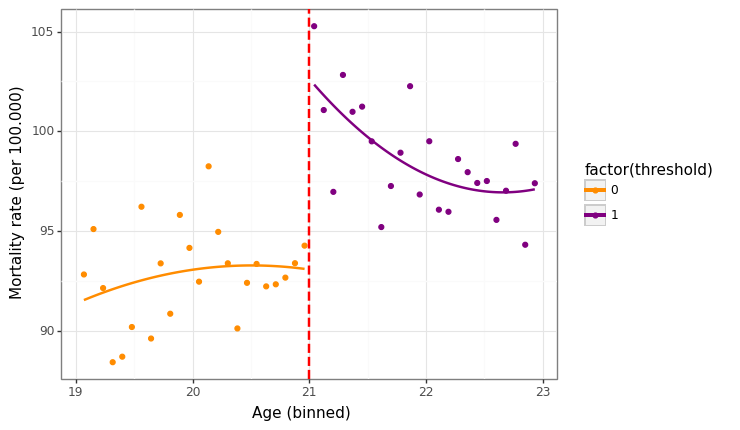

<ggplot: (8783677890115)>

In [14]:
(ggplot(data=alc_df, mapping=aes(x='agecell', y='all', 
                                 color='factor(threshold)'))+
       geom_point()+
 scale_color_manual(values=['darkorange', 'purple'])+
 geom_smooth(method='lm',
             formula = 'y ~ x+I(x**2)',se=False)+
 geom_vline(xintercept = 21, color = "red", size = 1, linetype = "dashed")+
 labs(y = "Mortality rate (per 100.000)",
       x = "Age (binned)")+
 theme_bw()
)

Through these falsification tests, we know that we can trust our results are good. There are other ways to verify such, but they are beyond the scope of our course.